These exercises are part of practice in Chaperter 6 "Machine Learning", of online courses "Become a data scientist" [www.dataquest.io](https://www.dataquest.io/) 

<i> In general, ** data preparation ** may include feature selection, outlier removal, encoding, feature scaling and projection methods for dimensionality reduction, and more. </i>

## - Data preparation for linear gression <br>
<i> select_dtypes, drop, Seanborn heatmap plot of corr; </i> <br>
<i> feature selection: non-negligible correlation to target; non-collinearity; non-negligible variance; </i> <br>
<i> Dummy coding of categorical data;</i> <br>
<i> Imputation: fill missing data; <br>
KFold & cross_val_score

# Example of feature preparation for LR

In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('../../../dataquest/datafile/6-4-1-AmesHousing.txt', 
                   delimiter='\t')

In [4]:
target = 'SalePrice'
train = data[:1460]
test = data[1460:]
print(train.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Order              1460 non-null int64
PID                1460 non-null int64
MS SubClass        1460 non-null int64
MS Zoning          1460 non-null object
Lot Frontage       1211 non-null float64
Lot Area           1460 non-null int64
Street             1460 non-null object
Alley              109 non-null object
Lot Shape          1460 non-null object
Land Contour       1460 non-null object
Utilities          1460 non-null object
Lot Config         1460 non-null object
Land Slope         1460 non-null object
Neighborhood       1460 non-null object
Condition 1        1460 non-null object
Condition 2        1460 non-null object
Bldg Type          1460 non-null object
House Style        1460 non-null object
Overall Qual       1460 non-null int64
Overall Cond       1460 non-null int64
Year Built         1460 non-null int64
Year Remod/Add     1460 non-null int64
Roof Style         14

In [5]:
numerical_train = train.select_dtypes(include=['int64', 'float'])
# has to be 'int64'. In instruction, it was 'int' but it doesn't work here
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add',
                        'Garage Yr Blt', 'Mo Sold', 'Yr Sold'], axis=1)
null_series = numerical_train.isnull().sum()
print(null_series)

Order                0
MS SubClass          0
Lot Frontage       249
Lot Area             0
Overall Qual         0
Overall Cond         0
Mas Vnr Area        11
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       1
Bsmt Half Bath       1
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
TotRms AbvGrd        0
Fireplaces           0
Garage Cars          0
Garage Area          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
SalePrice            0
dtype: int64


In [6]:
full_cols_series = null_series[null_series == 0]
print(len(full_cols_series))

25


### Find columns apparently affect price & remove non relevent ones: 

In [7]:
train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64


### seaborn.heatmap(corr)

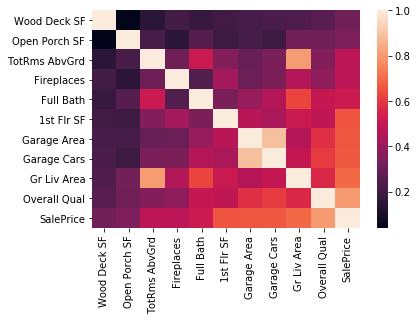

In [8]:
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat = train_subset[strong_corrs.index].corr()
seaborn.heatmap(corrmat)

### drop one of each highly correlated column pair (collinearity)

In [9]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(target).index

clean_test = test[final_corr_cols.index].dropna()

lr = LinearRegression()
lr.fit(train[features], train[target])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

34173.9762919
41032.0261202


### How about removing the feature with low variance ?
For math calcuations, the pandas table is treated as if a variable

In [10]:
unit_train = (train[features] - train[features].min())/(train[features].max()
                - train[features].min())
sorted_vars = unit_train.var().sort_values()
print(sorted_vars)

Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


In [11]:
features = features.drop('Open Porch SF')

lr = LinearRegression()
lr.fit(train[features], train[target])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse2 = mean_squared_error(train_predictions, train[target])
test_mse2 = mean_squared_error(test_predictions, clean_test[target])

train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)

print(train_rmse2)
print(test_rmse2)

34372.6967078
40591.4270244


# Ordinary Least Squares (OLS)
It is normally used for problems with elements no more than few millions. On large dataset, gradient descent method should be used. <br>
<br>
OLS finds the solution for $Xa=y$, where $X\in\mathbb{R}^{m\times n}$, is the matrix of m sets of samples with n features, $y\in\mathbb{R}^{m}$ is results of m trainings. $a\in\mathbb{R}^{n}$ is the coefficients to be found. OLS solution is:<br>
    $a=(X^TX)^{-1}X^Ty$

In [12]:
features = ['Wood Deck SF', 'Fireplaces', 'Full Bath', '1st Flr SF', 
            'Garage Area', 'Gr Liv Area', 'Overall Qual']
X = train[features]
y = train[target]

first_term = np.linalg.inv(np.dot(np.transpose(X), X))
second_term = np.dot(np.transpose(X), y)
a = np.dot(first_term, second_term)
print(a)

[    53.75693376  18232.3137575   -6434.65300989     22.53151963
     86.81522574     28.08976713  11397.64135314]


# Categorical data: dummy coding
No need to use train[one_text_col].astype('category'), or pd.Categorical, or pd.factorize https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers. Have not find a good example of using categorical code yet.

In [21]:
data['Utilities'].value_counts()

AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64

In [18]:
# get no-null text column names of train dataframe
null_series = train.isnull().sum()  # a series of null data counts
df_no_null = train[null_series[null_series==0].index]
text_col = df_no_null.select_dtypes(include=['object']).columns
print(text_col)

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Electrical',
       'Kitchen Qual', 'Functional', 'Paved Drive', 'Sale Type',
       'Sale Condition'],
      dtype='object')


In [23]:
print(type(null_series))

<class 'pandas.core.series.Series'>


In [19]:
print(train.shape)
for col in text_col:
    col_dummies = pd.get_dummies(train[col])
    train = pd.concat([train, col_dummies], axis=1)
    del train[col]
    
print(train.shape)

(1460, 82)
(1460, 236)


## Often need to create new column (feature)
Both 'Year Remov/add' (remodel/addition), and 'Year Built' are not very meanful by itself, but the year difference is more meanful in terms of 'SalePrice'. So create a new column

In [22]:
train['years_until_remod'] = train['Year Remod/Add'] - train['Year Built']

# Imputation
Replacing missing data with substituted values.<br>
Assume we would like to keep the columns no more than 25% missing data, given the limited number of sampling.

In [24]:
# find columns with less than 25% missing data
df_missing_values = train[null_series[(null_series>0) & (null_series < 584)].index]
print(df_missing_values.isnull().sum())
print(df_missing_values.dtypes)

Lot Frontage      249
Mas Vnr Type       11
Mas Vnr Area       11
Bsmt Qual          40
Bsmt Cond          40
Bsmt Exposure      41
BsmtFin Type 1     40
BsmtFin SF 1        1
BsmtFin Type 2     41
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      1
Bsmt Half Bath      1
Garage Type        74
Garage Yr Blt      75
Garage Finish      75
Garage Qual        75
Garage Cond        75
dtype: int64
Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Qual        object
Garage Cond        object
dtype: object


## Amazing how simple the way df.mean() and df.fillna() works for multiple column dataframe, with null values

In [25]:
float_cols = df_missing_values.select_dtypes(include=['float'])
float_cols = float_cols.fillna(float_cols.mean())
print(float_cols.isnull().sum())

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
dtype: int64


_____________________
# Re-Do feature engineering on the dataframe

- Handle missing values:
    - All columns:
        - Drop any with 5% or more missing values **for now**.
    - Text columns:
        - Drop any with 1 or more missing values **for now**.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in that column

1: All collumns: Drop those with 5% or more missing values.

In [96]:
data = pd.read_csv('../../../dataquest/datafile/6-4-1-AmesHousing.txt', 
                   delimiter='\t')
data_missing = data.isnull().sum()
drop_clns = data_missing[data_missing>(len(data)/20.0)].index
data = data.drop(drop_clns, axis=1)

In [97]:
print(len(data_missing), len(drop_clns), data.shape[1])

82 11 71


2: For text columns, drop all columns with 1 or more missing values.

In [98]:
text_missing_cts = data.select_dtypes(include='object').isnull().sum()
text_drops = text_missing_cts[text_missing_cts>0].index
data = data.drop(text_drops, axis=1)
print(data.shape)

(2930, 64)


3: For numerical columns with missing values, fill in with the most common values in columns:

In [99]:
num_missing = data.select_dtypes(include='number').isnull().sum()
fill_clns = num_missing[(num_missing<=(len(data)/20.0)) & (num_missing>0)].index
fill_dict = data[fill_clns].mode()
print(type(fill_dict))
print(fill_dict)

<class 'pandas.core.frame.DataFrame'>
   Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
0           0.0           0.0           0.0          0.0            0.0   

   Bsmt Full Bath  Bsmt Half Bath  Garage Cars  Garage Area  
0             0.0             0.0          2.0          0.0  


In [100]:
fill_dict = fill_dict.to_dict(orient='records')[0]
# 'shift'+'Tab' help: orient='records' gives [{cln -> value, ..., cln -> value}]
# so, ...[0] gives {cln -> value, ..., cln -> value}
print(fill_dict)

{'Bsmt Unf SF': 0.0, 'Bsmt Full Bath': 0.0, 'Garage Area': 0.0, 'Garage Cars': 2.0, 'Bsmt Half Bath': 0.0, 'Mas Vnr Area': 0.0, 'Total Bsmt SF': 0.0, 'BsmtFin SF 1': 0.0, 'BsmtFin SF 2': 0.0}


## Amazing again, how fillna works with dataframe (and using dictionary)
and use df.isnull().sum().value_counts() to check missing values

In [101]:
data = data.fillna(fill_dict)
print(data.isnull().sum().value_counts())

0    64
dtype: int64


4: Create new features, and drop not-needed columns:

In [102]:
yrs_before_sold = data['Yr Sold'] - data['Year Built']
yrs_before_sold[yrs_before_sold<0]

2180   -1
dtype: int64

In [103]:
yrs_before_remod = data['Yr Sold'] - data['Year Remod/Add']
yrs_before_remod[yrs_before_remod<0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [104]:
data['Yr before sale'] = yrs_before_sold
data['Yr before remod'] = yrs_before_remod

data = data.drop([1702, 2180, 2181], axis=0)
data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)
print(data.shape)

(2927, 64)


In [105]:
# drop columns that aren't usefule for ML
data = data.drop(['PID', 'Order'], axis=1)

5: Drop leak data about final sale. [leak data:](https://machinelearningmastery.com/data-leakage-machine-learning/) <i>"if any other feature whose value would not actually be available in practice at the time you’d want to use the model to make a prediction, is a feature that can introduce leakage to your model"; "when the data you are using to train a machine learning algorithm happens to have the information you are trying to predict." </i> Perhaps more

In [106]:
data = data.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

5: Only keep numerical columns with high correlation with 'SalePrice'

In [107]:
# verify that include='number' is equivalent to include=['int64', 'float64] here
num_df = data.select_dtypes(include='number')
print(num_df.shape)
num_df = data.select_dtypes(include=['int64', 'float64'])
print(num_df.shape)

(2927, 33)
(2927, 33)


In [108]:
num_corr_sale = num_df.corr()['SalePrice'].abs().sort_values()
print(type(num_corr_sale))
print(num_corr_sale)
num_drop = num_corr_sale[num_corr_sale < 0.4]
data = data.drop(num_drop.index, axis=1)
print(data.shape)

<class 'pandas.core.series.Series'>
BsmtFin SF 2       0.006127
Misc Val           0.019273
3Ssn Porch         0.032268
Bsmt Half Bath     0.035875
Low Qual Fin SF    0.037629
Pool Area          0.068438
MS SubClass        0.085128
Overall Cond       0.101540
Screen Porch       0.112280
Kitchen AbvGr      0.119760
Enclosed Porch     0.128685
Bedroom AbvGr      0.143916
Bsmt Unf SF        0.182751
Lot Area           0.267520
2nd Flr SF         0.269601
Bsmt Full Bath     0.276258
Half Bath          0.284871
Open Porch SF      0.316262
Wood Deck SF       0.328183
BsmtFin SF 1       0.439284
Fireplaces         0.474831
TotRms AbvGrd      0.498574
Mas Vnr Area       0.506983
Yr before remod    0.534985
Full Bath          0.546118
Yr before sale     0.558979
1st Flr SF         0.635185
Garage Area        0.641425
Total Bsmt SF      0.644012
Garage Cars        0.648361
Gr Liv Area        0.717596
Overall Qual       0.801206
SalePrice          1.000000
Name: SalePrice, dtype: float64
(2927, 3

In [109]:
print(num_drop.index)

Index(['BsmtFin SF 2', 'Misc Val', '3Ssn Porch', 'Bsmt Half Bath',
       'Low Qual Fin SF', 'Pool Area', 'MS SubClass', 'Overall Cond',
       'Screen Porch', 'Kitchen AbvGr', 'Enclosed Porch', 'Bedroom AbvGr',
       'Bsmt Unf SF', 'Lot Area', '2nd Flr SF', 'Bsmt Full Bath', 'Half Bath',
       'Open Porch SF', 'Wood Deck SF'],
      dtype='object')


6: Dummy coding the text columns that are meant to be categorical according to document, with less than 10 unique values:

In [114]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config",
                    "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", 
                    "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", 
                    "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", 
                    "Sale Type", "Sale Condition"]
# use set intersection to find the columns still in table:
cols_in_df = list(set(nominal_features) & set(data.columns))

# The solution code (Mission240Solutions.ipynb) uses loop to find out, a bit of more work:
# cols_to_code = []
# for col in nominal_features:
#     if col in data.columns:
#         cols_to_code.append(col)
print(cols_in_df)
unique_values = data[cols_in_df].apply(lambda x: len(x.value_counts()))
print(unique_values)
cols_to_code = list(set(cols_in_df) & set(unique_values[unique_values<=10].index))
print(cols_to_code)

['Roof Matl', 'Central Air', 'House Style', 'Exterior 1st', 'Neighborhood', 'Foundation', 'Land Contour', 'Exterior 2nd', 'Roof Style', 'MS Zoning', 'Lot Config', 'Heating', 'Condition 2', 'Condition 1', 'Bldg Type', 'Street']
Roof Matl        8
Central Air      2
House Style      8
Exterior 1st    16
Neighborhood    28
Foundation       6
Land Contour     4
Exterior 2nd    17
Roof Style       6
MS Zoning        7
Lot Config       5
Heating          6
Condition 2      8
Condition 1      9
Bldg Type        5
Street           2
dtype: int64
['Roof Matl', 'Central Air', 'House Style', 'Foundation', 'Land Contour', 'Roof Style', 'MS Zoning', 'Lot Config', 'Heating', 'Condition 2', 'Condition 1', 'Bldg Type', 'Street']


In [115]:
dummy_cols = pd.get_dummies(data[cols_to_code])
print(dummy_cols.shape)
data = pd.concat([data, dummy_cols], axis=1)
print(data.shape)
# in solution code, the text columns are first converted to 'category' type, then use 
# include='category' in select_dtypes to select these columns for get_dummies operation

(2927, 76)
(2927, 115)


7: To summarize all the work in functions:

In [124]:
def drop_filla_create_features(df):
    # drop any columns with >5% missing data
    num_missing = df.isnull().sum()  # a series of missing numbers
    drop_cols = num_missing[num_missing>(len(df)/20.0)].index    # list of columns with >5% missing
    df = df.drop(drop_cols, axis=1)
    
    # drop text columns with any missing data
    text_missing_cts = df.select_dtypes(include=['object']).isnull().sum()
    text_drops = text_missing_cts[text_missing_cts>0].index    # text columns with missing data
    df = df.drop(text_drops, axis=1)
    
    # fillna missing numerical data with most likely values (mode):
    numerical_missing = df.select_dtypes(include='number').isnull().sum()
    numerical_missing_cols = numerical_missing[numerical_missing>0].index
    col_mode_dict = df[numerical_missing_cols].mode().to_dict(orient='records')[0]
    df = df.fillna(col_mode_dict)
    
    # create some new features:
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    
    # drop the columns that believed to cause data leak:
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", 
                  "Year Built", "Year Remod/Add"], axis=1)    
    return df

def select_encode_features(df, corr_threshold=0.4, uniq_threshold=10):
    # drop numerical columns that weakly correlated to 'SalePrice'
    numerical_df = df.select_dtypes(include=['int64', 'float64'])   # include='number' also ok
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < corr_threshold].index, axis=1)
    
    # dummy coding text columns
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", 
                    "Lot Config","Neighborhood", "Condition 1", "Condition 2", "Bldg Type", 
                    "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", 
                    "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    cols_in_df = list(set(nominal_features) & set(df.columns))
    unique_values = df[cols_in_df].apply(lambda x: len(x.value_counts()))
    cols_to_code = unique_values[unique_values<=uniq_threshold].index
    dummy_cols = pd.get_dummies(df[cols_to_code])
    df = pd.concat([df, dummy_cols], axis=1)
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values=[]
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test['SalePrice'], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

    
data = pd.read_csv('../../../dataquest/datafile/6-4-1-AmesHousing.txt', 
                   delimiter='\t')
step1_df = drop_filla_create_features(data)
step2_df = select_encode_features(step1_df)

rmse = train_and_test(step2_df)
print(rmse)
rmse = train_and_test(step2_df, k=4)
print(rmse)

35064.6506193
[28857.254408702953, 29090.03994169912, 27543.561208889907, 39556.065159260463]
31261.7301796


 <i> test_rmse was 40591.4270244 for previous quick testing. Now it is 31261 (after quite some more work) <i>

In [126]:
fold=4
kf = KFold(fold, shuffle=True, random_state=1)
model = LinearRegression()
numeric_df = step2_df.select_dtypes(include=['integer', 'float'])
features = numeric_df.columns.drop("SalePrice")
mses = cross_val_score(model, step2_df[features], 
                step2_df['SalePrice'], scoring='neg_mean_squared_error', cv=kf)
rmse = np.sqrt(-1*mses)
print(rmse)

[ 38449.50868425  27976.34653088  28708.14818451  30822.4088079 ]
